# Part I: Analysis of Raw Data

Load necessary packages

In [2]:
library(car)
library(MASS)
library(rms)
library(glmnet)
library(leaps)
require(ggplot2)
set.seed(1234)

Read the BodyFat data

In [19]:
fat = read.csv("~/Desktop/STAT628/BodyFat.csv", header = T)

### 1.1 Examine the Bodyfat Data

Use the density plot of `BODYFAT` to find whether there exist abnormal data, and obtain the corresponding `IDNO` of these abnormal observations.

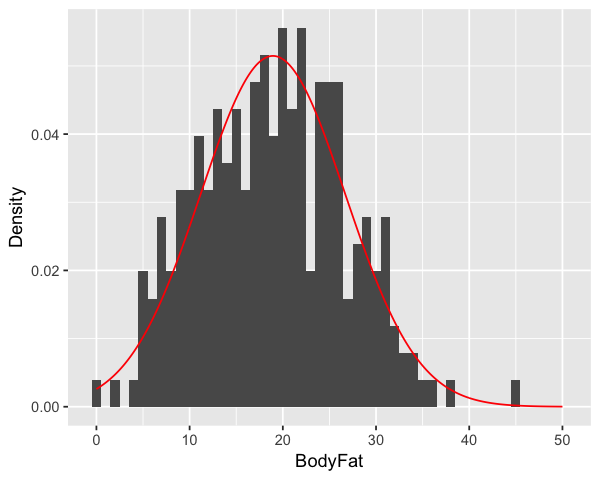

In [22]:
x <- seq(0, 50, length.out=500)
df.fat <- with(fat, data.frame(x = x, y = dnorm(x, mean(BODYFAT), sd(BODYFAT))))
ggplot(fat)+
  geom_histogram(aes(x = BODYFAT, y = ..density..),binwidth = 1)+
  xlab("BodyFat")+
  ylab("Density")+
  geom_line(data = df.fat, aes(x = x, y = y), color = "red")
options(repr.plot.width=5, repr.plot.height=4)

In [23]:
fat[which(fat$BODYFAT>40|fat$BODYFAT==0),]$IDNO

[1] 182 216

We think that observations with `IDNO` equals to 182 and 216 are abnormal points in this data set.

### 1.2 Examine the Relationship Between Density and Bodyfat

According to 谁谁谁's experiment result, the relationship between density and bodyfat can be expressed as:

$$\text{Body Fat}\ (100*B)= \frac{495}{\text{Density}\ (gm/cm^3)} - 450$$

Use the knwon relationship between `DENSITY` and `BODYFAT` to detect whether there exist abnormal observations. 


Call:
lm(formula = fat$BODYFAT ~ den.inverse)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.0510 -0.1612 -0.0480  0.0700 15.3135 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -405.786      3.994  -101.6   <2e-16 ***
den.inverse  448.183      4.214   106.4   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.142 on 250 degrees of freedom
Multiple R-squared:  0.9784,	Adjusted R-squared:  0.9783 
F-statistic: 1.131e+04 on 1 and 250 DF,  p-value: < 2.2e-16


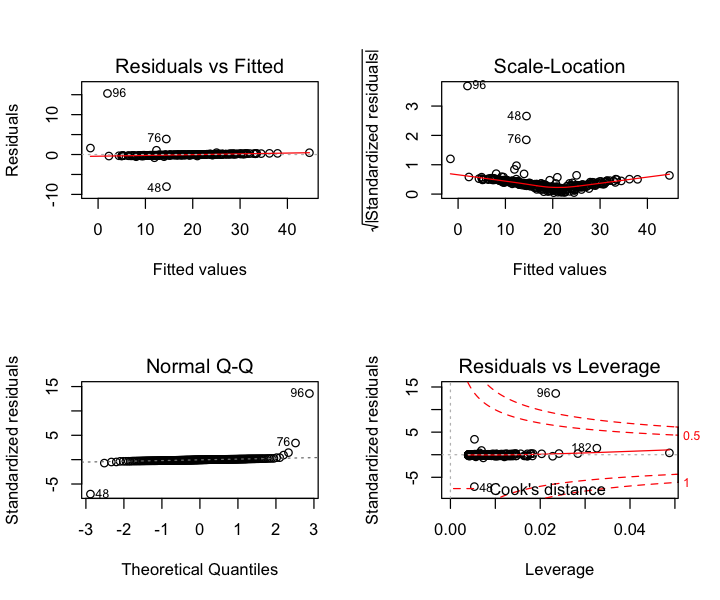

In [24]:
den.inverse = 1/fat$DENSITY
outlier.test.m1 = lm(fat$BODYFAT~den.inverse)
summary(outlier.test.m1)
options(repr.plot.width=6, repr.plot.height=5)
par(mfcol=c(2,2))
plot(outlier.test.m1)

### 1.3 Examine the Relationship Between Weight, Height, and Adiposity

The relationship between Weight, Height, and Adiposity can be expressed by:

$$\text{Body Adiposity Index} = \frac{\text{Hip circumference in cm}}{\text{Height in m}^{3/2}} $$

We use these relationship to detect whether there exist abnormal observations in our data set.


Call:
lm(formula = fat$ADIPOSITY ~ bmi)

Residuals:
    Min      1Q  Median      3Q     Max 
-19.595  -1.844  -0.235   1.633  19.507 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  20.9685     0.5954  35.218  < 2e-16 ***
bmi         121.0993    15.1445   7.996 4.77e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.262 on 250 degrees of freedom
Multiple R-squared:  0.2037,	Adjusted R-squared:  0.2005 
F-statistic: 63.94 on 1 and 250 DF,  p-value: 4.767e-14


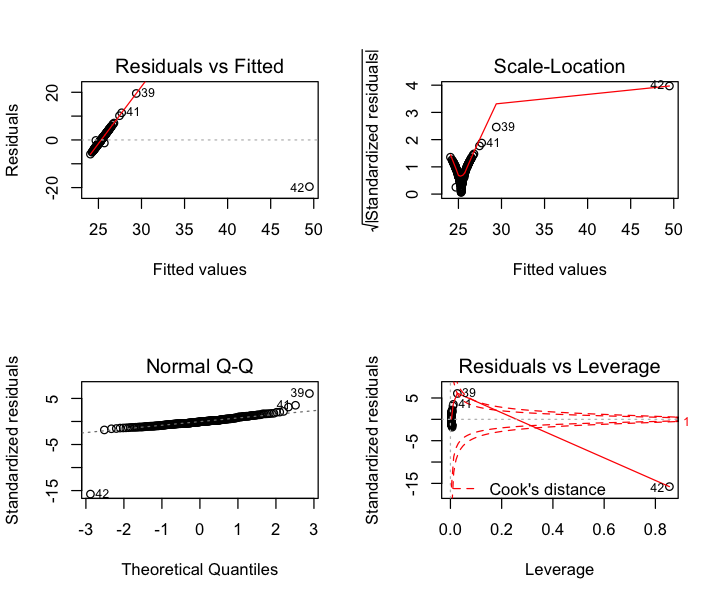

In [25]:
bmi=fat$WEIGHT/(fat$HEIGHT^2)
outlier.test.m2 = lm(fat$ADIPOSITY~bmi)
summary(outlier.test.m2)
options(repr.plot.width=6, repr.plot.height=5)
par(mfcol=c(2,2))
plot(outlier.test.m2)

According to the result shown above, we think observations with `IDNO` equals to 42,41,39 are the outliers.

### 1.4 Remove the outliers

Remove the outliers we found before and use multiple linear regression to fit the full model with remained observations.


Call:
lm(formula = BODYFAT ~ ., data = fat.rm)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.8994 -2.9023 -0.1588  2.6850  9.1143 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -25.03314   37.46005  -0.668  0.50464    
AGE           0.06054    0.02996   2.020  0.04452 *  
WEIGHT       -0.09351    0.10437  -0.896  0.37120    
HEIGHT        0.24803    0.51155   0.485  0.62823    
ADIPOSITY     0.75382    0.72924   1.034  0.30236    
NECK         -0.37399    0.21826  -1.714  0.08797 .  
CHEST        -0.14922    0.10399  -1.435  0.15266    
ABDOMEN       0.83122    0.08719   9.534  < 2e-16 ***
HIP          -0.16476    0.14036  -1.174  0.24167    
THIGH         0.15001    0.13703   1.095  0.27477    
KNEE         -0.12707    0.23883  -0.532  0.59521    
ANKLE         0.15839    0.20765   0.763  0.44637    
BICEPS        0.14743    0.16072   0.917  0.35993    
FOREARM       0.23501    0.19273   1.219  0.22395    
WRIST        -1.58720    0.50837 

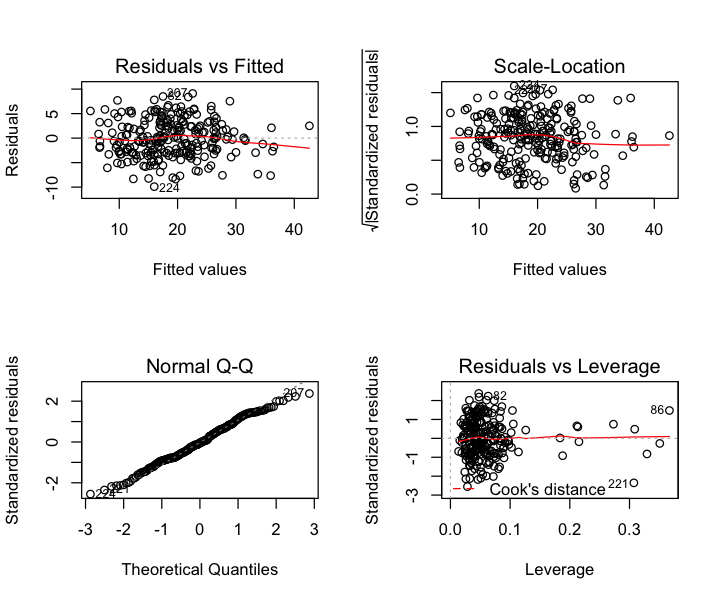

In [32]:
# fit the full model
fat.rm = fat[-c(182,76,96,48,42,41,39),]
fat.rm$DENSITY = NULL
fat.rm$IDNO = NULL
write.csv(fat.rm,"clean_data.csv",row.names=FALSE)
test.rmoutlier.first = lm(BODYFAT~.,fat.rm)
summary(test.rmoutlier.first)
options(repr.plot.width=6, repr.plot.height=5)
par(mfcol=c(2,2))
plot(test.rmoutlier.first)

### 1.5 Examine Normality of the Response Variable

First we draw the Normal Q-Q plot of our full model.

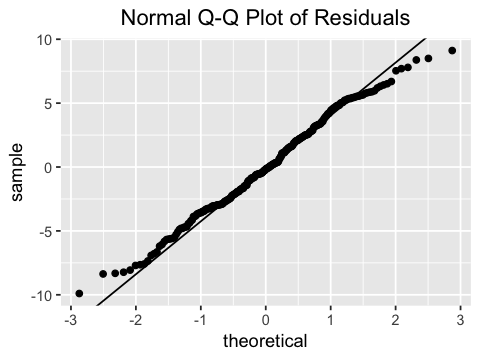

In [27]:
normal.qq.plot <- function(residual)
{
  y <- quantile(residual[!is.na(residual)], c(0.25, 0.75))
  x <- qnorm(c(0.25, 0.75))
  slope <- diff(y)/diff(x)
  int <- y[1L] - slope * x[1L]
  d <- data.frame(res = residual)
  ggplot(d, aes(sample = res))+
    stat_qq()+
    geom_abline(slope = slope, intercept = int)+
    ggtitle("Normal Q-Q Plot of Residuals")+
    theme(plot.title = element_text(hjust = 0.5))
}
options(repr.plot.width=4, repr.plot.height=3)
normal.qq.plot(test.rmoutlier.first$residuals)

From the normal QQ plot above, we roughly think the residuals are normal distribution. Then, we conduct box-cox transformation on our full model to find out whether we need transform our data set.

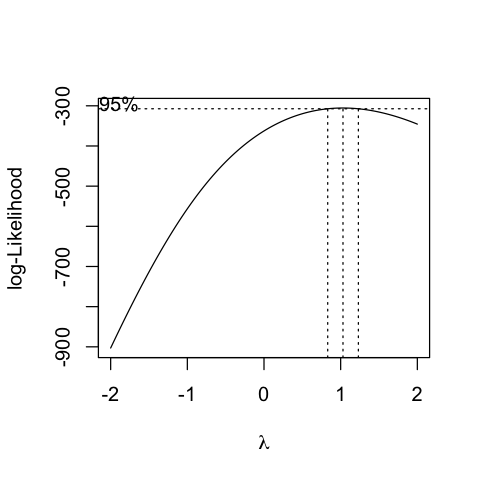

In [28]:
options(repr.plot.width=4, repr.plot.height=4)
par(mfrow=c(1,1))
boxcox(test.rmoutlier.first)

From the above result, the $\lambda$ almost equals to 1, therefore we do not transform our data.

### 1.6 Data Visualization

First we make density plots of each variables in out bodyfat data set.

不知道为什么这里跑不出来，但是我的R上是可以的，如果不行就直接把图片弄上来

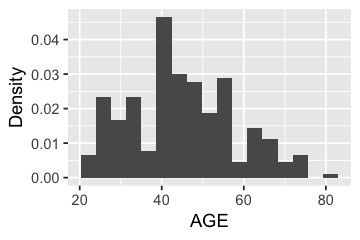

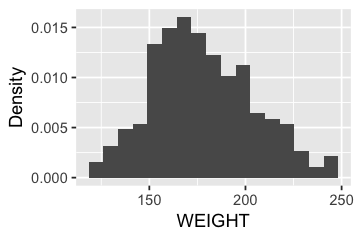

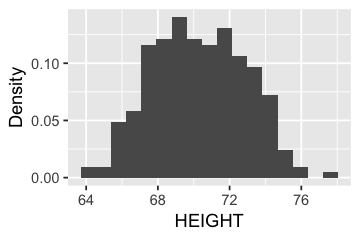

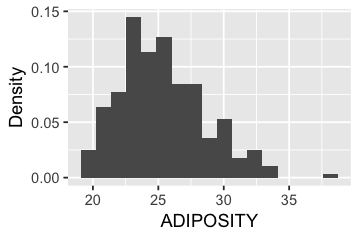

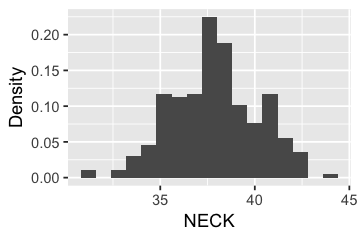

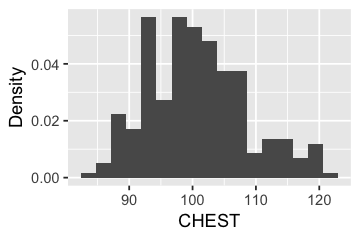

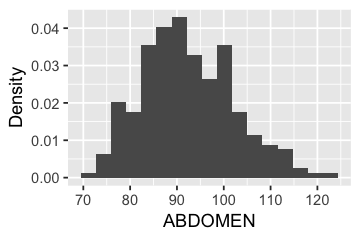

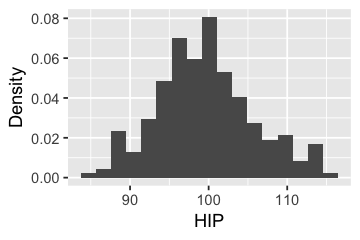

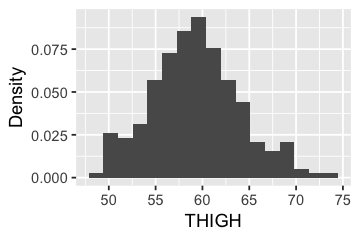

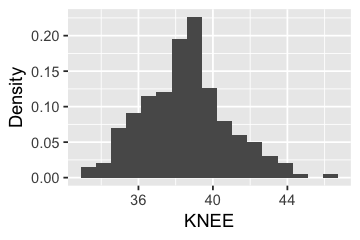

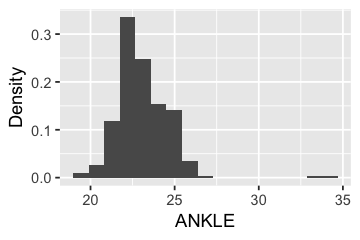

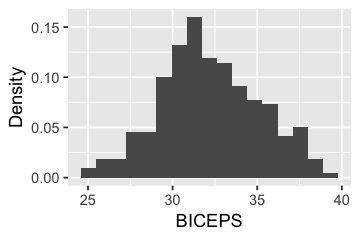

ERROR: Error in `[.data.frame`(fat.rm, , i): undefined columns selected


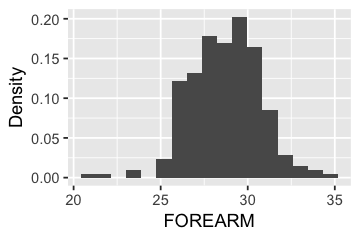

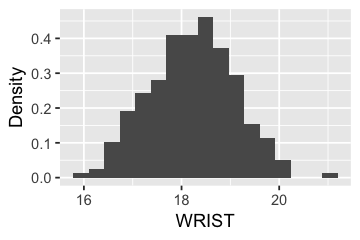

In [35]:
g = list()
df = list()
options(repr.plot.width=3, repr.plot.height=2)
for (i in 2:17) {
  fat.var = data.frame(x = fat.rm[,i])
  diff = max(fat.var$x)-min(fat.var$x)
  g[[i-1]] = print(ggplot(fat.var)+
                   geom_histogram(aes(x = x, y = ..density..),binwidth = diff/round(sqrt(length(fat.var$x))))+
                   xlab(colnames(fat.rm[i]))+
                   ylab("Density"))
}
do.call(grid.arrange,g)

# Part III: Variable Selection

First we fit the full model and the null model.

In [36]:
lm.full = lm(BODYFAT~.,fat.rm)
lm.null = lm(BODYFAT~1,fat.rm)

### 3.1 Variable Selection Based on $C_p$

In [37]:
temp <- regsubsets(fat.rm[,-c(1:3)],y=fat.rm$BODYFAT ,nbest=1,method="exhaustive",nvmax=4)
temp.mat <- cbind(summary(temp)$which,
                  summary(temp)$rsq,
                  summary(temp)$adjr2,
                  summary(temp)$cp)
dimnames(temp.mat)[[2]] <- c(dimnames(summary(temp)$which)[[2]],"rsq","adjrsq","cp")

In [38]:
temp.mat

(Intercept),HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,rsq,adjrsq,cp
1,0,0,0,0,1,0,0,0,0,0,0,0,0.6738741,0.6725320,49.540539
1,0,0,0,0,1,0,0,0,0,0,0,1,0.7113312,0.7089455,18.170571
1,1,0,0,0,1,0,0,0,0,0,0,1,0.7271336,0.7237369,6.092467
1,1,0,0,1,1,0,0,0,0,0,0,1,0.7311910,0.7267108,4.477826


### 3.2 Variable Selection Based on AIC and BIC

**3.2.1** Both sides

In [39]:
model.aic.both <- step(lm.full, direction = "both", k = 2)
summary(model.aic.both)

Start:  AIC=685.59
BODYFAT ~ AGE + WEIGHT + HEIGHT + ADIPOSITY + NECK + CHEST + 
    ABDOMEN + HIP + THIGH + KNEE + ANKLE + BICEPS + FOREARM + 
    WRIST

            Df Sum of Sq    RSS    AIC
- HEIGHT     1      3.64 3562.3 683.84
- KNEE       1      4.38 3563.0 683.89
- ANKLE      1      9.00 3567.7 684.21
- WEIGHT     1     12.42 3571.1 684.44
- BICEPS     1     13.02 3571.7 684.49
- ADIPOSITY  1     16.53 3575.2 684.73
- THIGH      1     18.54 3577.2 684.86
- HIP        1     21.32 3580.0 685.05
- FOREARM    1     23.01 3581.7 685.17
<none>                   3558.7 685.59
- CHEST      1     31.86 3590.5 685.77
- NECK       1     45.43 3604.1 686.70
- AGE        1     63.15 3621.8 687.90
- WRIST      1    150.82 3709.5 693.76
- ABDOMEN    1   1406.31 4965.0 765.18

Step:  AIC=683.84
BODYFAT ~ AGE + WEIGHT + ADIPOSITY + NECK + CHEST + ABDOMEN + 
    HIP + THIGH + KNEE + ANKLE + BICEPS + FOREARM + WRIST

            Df Sum of Sq    RSS    AIC
- KNEE       1      4.12 3566.4 682.12
- 


Call:
lm(formula = BODYFAT ~ AGE + ADIPOSITY + NECK + CHEST + ABDOMEN + 
    HIP + FOREARM + WRIST, data = fat.rm)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.5188 -2.8039 -0.3798  2.7513  9.2316 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.16132    7.13613   0.583 0.560360    
AGE          0.05386    0.02602   2.070 0.039532 *  
ADIPOSITY    0.61204    0.23245   2.633 0.009023 ** 
NECK        -0.39384    0.20521  -1.919 0.056165 .  
CHEST       -0.20880    0.08949  -2.333 0.020483 *  
ABDOMEN      0.79910    0.08245   9.692  < 2e-16 ***
HIP         -0.18453    0.10020  -1.842 0.066794 .  
FOREARM      0.26155    0.18066   1.448 0.149016    
WRIST       -1.65239    0.45164  -3.659 0.000313 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.915 on 236 degrees of freedom
Multiple R-squared:  0.7412,	Adjusted R-squared:  0.7324 
F-statistic: 84.48 on 8 and 236 DF,  p-value: < 2.2e-16


In [40]:
model.bic.both <- step(lm.full, direction = "both", k = log(length(fat.rm[,1])))
summary(model.bic.both)

Start:  AIC=738.11
BODYFAT ~ AGE + WEIGHT + HEIGHT + ADIPOSITY + NECK + CHEST + 
    ABDOMEN + HIP + THIGH + KNEE + ANKLE + BICEPS + FOREARM + 
    WRIST

            Df Sum of Sq    RSS    AIC
- HEIGHT     1      3.64 3562.3 732.86
- KNEE       1      4.38 3563.0 732.91
- ANKLE      1      9.00 3567.7 733.23
- WEIGHT     1     12.42 3571.1 733.46
- BICEPS     1     13.02 3571.7 733.50
- ADIPOSITY  1     16.53 3575.2 733.74
- THIGH      1     18.54 3577.2 733.88
- HIP        1     21.32 3580.0 734.07
- FOREARM    1     23.01 3581.7 734.19
- CHEST      1     31.86 3590.5 734.79
- NECK       1     45.43 3604.1 735.72
- AGE        1     63.15 3621.8 736.92
<none>                   3558.7 738.11
- WRIST      1    150.82 3709.5 742.78
- ABDOMEN    1   1406.31 4965.0 814.20

Step:  AIC=732.86
BODYFAT ~ AGE + WEIGHT + ADIPOSITY + NECK + CHEST + ABDOMEN + 
    HIP + THIGH + KNEE + ANKLE + BICEPS + FOREARM + WRIST

            Df Sum of Sq    RSS    AIC
- KNEE       1      4.12 3566.4 727.64
- 


Call:
lm(formula = BODYFAT ~ AGE + ADIPOSITY + CHEST + ABDOMEN + WRIST, 
    data = fat.rm)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.3984 -2.6892 -0.3401  3.1022  8.8391 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -3.85046    5.88498  -0.654 0.513557    
AGE          0.07571    0.02139   3.539 0.000482 ***
ADIPOSITY    0.54029    0.22576   2.393 0.017476 *  
CHEST       -0.21987    0.08871  -2.478 0.013888 *  
ABDOMEN      0.70703    0.07144   9.896  < 2e-16 ***
WRIST       -2.05707    0.36948  -5.567 6.93e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.954 on 239 degrees of freedom
Multiple R-squared:  0.7326,	Adjusted R-squared:  0.727 
F-statistic:   131 on 5 and 239 DF,  p-value: < 2.2e-16


Backward这些我加不动了，你自己加一下md注释吧…


In [41]:
#AIC and BIC

#direction=both
model.aic.both <- step(lm.full, direction = "both", k = 2)
summary(model.aic.both)

model.bic.both <- step(lm.full, direction = "both", k = log(length(fat.rm[,1])))
summary(model.bic.both)
#Seems BIC is more desirable than AIC.

#direction=backward
model.aic.backward <- step(lm.full, direction = "backward", k = 2)
summary(model.aic.backward)

model.bic.backward <- step(lm.full, direction = "backward", k = log(length(fat.rm[,1])))
summary(model.bic.backward)

#direction=forward
model.aic.forward <- step(lm.null,~ AGE + WEIGHT + HEIGHT + ADIPOSITY + NECK + CHEST + 
                            ABDOMEN + HIP + THIGH + KNEE + ANKLE + BICEPS + FOREARM + 
                            WRIST, direction = "forward", k = 2)
summary(model.aic.forward)

model.bic.forward <- step(lm.null,~ AGE + WEIGHT + HEIGHT + ADIPOSITY + NECK + CHEST + 
                            ABDOMEN + HIP + THIGH + KNEE + ANKLE + BICEPS + FOREARM + 
                            WRIST, direction = "forward", k = log(length(fat.rm[,1])))
summary(model.bic.forward)


Start:  AIC=685.59
BODYFAT ~ AGE + WEIGHT + HEIGHT + ADIPOSITY + NECK + CHEST + 
    ABDOMEN + HIP + THIGH + KNEE + ANKLE + BICEPS + FOREARM + 
    WRIST

            Df Sum of Sq    RSS    AIC
- HEIGHT     1      3.64 3562.3 683.84
- KNEE       1      4.38 3563.0 683.89
- ANKLE      1      9.00 3567.7 684.21
- WEIGHT     1     12.42 3571.1 684.44
- BICEPS     1     13.02 3571.7 684.49
- ADIPOSITY  1     16.53 3575.2 684.73
- THIGH      1     18.54 3577.2 684.86
- HIP        1     21.32 3580.0 685.05
- FOREARM    1     23.01 3581.7 685.17
<none>                   3558.7 685.59
- CHEST      1     31.86 3590.5 685.77
- NECK       1     45.43 3604.1 686.70
- AGE        1     63.15 3621.8 687.90
- WRIST      1    150.82 3709.5 693.76
- ABDOMEN    1   1406.31 4965.0 765.18

Step:  AIC=683.84
BODYFAT ~ AGE + WEIGHT + ADIPOSITY + NECK + CHEST + ABDOMEN + 
    HIP + THIGH + KNEE + ANKLE + BICEPS + FOREARM + WRIST

            Df Sum of Sq    RSS    AIC
- KNEE       1      4.12 3566.4 682.12
- 


Call:
lm(formula = BODYFAT ~ AGE + ADIPOSITY + NECK + CHEST + ABDOMEN + 
    HIP + FOREARM + WRIST, data = fat.rm)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.5188 -2.8039 -0.3798  2.7513  9.2316 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.16132    7.13613   0.583 0.560360    
AGE          0.05386    0.02602   2.070 0.039532 *  
ADIPOSITY    0.61204    0.23245   2.633 0.009023 ** 
NECK        -0.39384    0.20521  -1.919 0.056165 .  
CHEST       -0.20880    0.08949  -2.333 0.020483 *  
ABDOMEN      0.79910    0.08245   9.692  < 2e-16 ***
HIP         -0.18453    0.10020  -1.842 0.066794 .  
FOREARM      0.26155    0.18066   1.448 0.149016    
WRIST       -1.65239    0.45164  -3.659 0.000313 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.915 on 236 degrees of freedom
Multiple R-squared:  0.7412,	Adjusted R-squared:  0.7324 
F-statistic: 84.48 on 8 and 236 DF,  p-value: < 2.2e-16


Start:  AIC=738.11
BODYFAT ~ AGE + WEIGHT + HEIGHT + ADIPOSITY + NECK + CHEST + 
    ABDOMEN + HIP + THIGH + KNEE + ANKLE + BICEPS + FOREARM + 
    WRIST

            Df Sum of Sq    RSS    AIC
- HEIGHT     1      3.64 3562.3 732.86
- KNEE       1      4.38 3563.0 732.91
- ANKLE      1      9.00 3567.7 733.23
- WEIGHT     1     12.42 3571.1 733.46
- BICEPS     1     13.02 3571.7 733.50
- ADIPOSITY  1     16.53 3575.2 733.74
- THIGH      1     18.54 3577.2 733.88
- HIP        1     21.32 3580.0 734.07
- FOREARM    1     23.01 3581.7 734.19
- CHEST      1     31.86 3590.5 734.79
- NECK       1     45.43 3604.1 735.72
- AGE        1     63.15 3621.8 736.92
<none>                   3558.7 738.11
- WRIST      1    150.82 3709.5 742.78
- ABDOMEN    1   1406.31 4965.0 814.20

Step:  AIC=732.86
BODYFAT ~ AGE + WEIGHT + ADIPOSITY + NECK + CHEST + ABDOMEN + 
    HIP + THIGH + KNEE + ANKLE + BICEPS + FOREARM + WRIST

            Df Sum of Sq    RSS    AIC
- KNEE       1      4.12 3566.4 727.64
- 


Call:
lm(formula = BODYFAT ~ AGE + ADIPOSITY + CHEST + ABDOMEN + WRIST, 
    data = fat.rm)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.3984 -2.6892 -0.3401  3.1022  8.8391 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -3.85046    5.88498  -0.654 0.513557    
AGE          0.07571    0.02139   3.539 0.000482 ***
ADIPOSITY    0.54029    0.22576   2.393 0.017476 *  
CHEST       -0.21987    0.08871  -2.478 0.013888 *  
ABDOMEN      0.70703    0.07144   9.896  < 2e-16 ***
WRIST       -2.05707    0.36948  -5.567 6.93e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.954 on 239 degrees of freedom
Multiple R-squared:  0.7326,	Adjusted R-squared:  0.727 
F-statistic:   131 on 5 and 239 DF,  p-value: < 2.2e-16


Start:  AIC=685.59
BODYFAT ~ AGE + WEIGHT + HEIGHT + ADIPOSITY + NECK + CHEST + 
    ABDOMEN + HIP + THIGH + KNEE + ANKLE + BICEPS + FOREARM + 
    WRIST

            Df Sum of Sq    RSS    AIC
- HEIGHT     1      3.64 3562.3 683.84
- KNEE       1      4.38 3563.0 683.89
- ANKLE      1      9.00 3567.7 684.21
- WEIGHT     1     12.42 3571.1 684.44
- BICEPS     1     13.02 3571.7 684.49
- ADIPOSITY  1     16.53 3575.2 684.73
- THIGH      1     18.54 3577.2 684.86
- HIP        1     21.32 3580.0 685.05
- FOREARM    1     23.01 3581.7 685.17
<none>                   3558.7 685.59
- CHEST      1     31.86 3590.5 685.77
- NECK       1     45.43 3604.1 686.70
- AGE        1     63.15 3621.8 687.90
- WRIST      1    150.82 3709.5 693.76
- ABDOMEN    1   1406.31 4965.0 765.18

Step:  AIC=683.84
BODYFAT ~ AGE + WEIGHT + ADIPOSITY + NECK + CHEST + ABDOMEN + 
    HIP + THIGH + KNEE + ANKLE + BICEPS + FOREARM + WRIST

            Df Sum of Sq    RSS    AIC
- KNEE       1      4.12 3566.4 682.12
- 


Call:
lm(formula = BODYFAT ~ AGE + ADIPOSITY + NECK + CHEST + ABDOMEN + 
    HIP + FOREARM + WRIST, data = fat.rm)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.5188 -2.8039 -0.3798  2.7513  9.2316 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.16132    7.13613   0.583 0.560360    
AGE          0.05386    0.02602   2.070 0.039532 *  
ADIPOSITY    0.61204    0.23245   2.633 0.009023 ** 
NECK        -0.39384    0.20521  -1.919 0.056165 .  
CHEST       -0.20880    0.08949  -2.333 0.020483 *  
ABDOMEN      0.79910    0.08245   9.692  < 2e-16 ***
HIP         -0.18453    0.10020  -1.842 0.066794 .  
FOREARM      0.26155    0.18066   1.448 0.149016    
WRIST       -1.65239    0.45164  -3.659 0.000313 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.915 on 236 degrees of freedom
Multiple R-squared:  0.7412,	Adjusted R-squared:  0.7324 
F-statistic: 84.48 on 8 and 236 DF,  p-value: < 2.2e-16


Start:  AIC=738.11
BODYFAT ~ AGE + WEIGHT + HEIGHT + ADIPOSITY + NECK + CHEST + 
    ABDOMEN + HIP + THIGH + KNEE + ANKLE + BICEPS + FOREARM + 
    WRIST

            Df Sum of Sq    RSS    AIC
- HEIGHT     1      3.64 3562.3 732.86
- KNEE       1      4.38 3563.0 732.91
- ANKLE      1      9.00 3567.7 733.23
- WEIGHT     1     12.42 3571.1 733.46
- BICEPS     1     13.02 3571.7 733.50
- ADIPOSITY  1     16.53 3575.2 733.74
- THIGH      1     18.54 3577.2 733.88
- HIP        1     21.32 3580.0 734.07
- FOREARM    1     23.01 3581.7 734.19
- CHEST      1     31.86 3590.5 734.79
- NECK       1     45.43 3604.1 735.72
- AGE        1     63.15 3621.8 736.92
<none>                   3558.7 738.11
- WRIST      1    150.82 3709.5 742.78
- ABDOMEN    1   1406.31 4965.0 814.20

Step:  AIC=732.86
BODYFAT ~ AGE + WEIGHT + ADIPOSITY + NECK + CHEST + ABDOMEN + 
    HIP + THIGH + KNEE + ANKLE + BICEPS + FOREARM + WRIST

            Df Sum of Sq    RSS    AIC
- KNEE       1      4.12 3566.4 727.64
- 


Call:
lm(formula = BODYFAT ~ AGE + ADIPOSITY + CHEST + ABDOMEN + WRIST, 
    data = fat.rm)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.3984 -2.6892 -0.3401  3.1022  8.8391 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -3.85046    5.88498  -0.654 0.513557    
AGE          0.07571    0.02139   3.539 0.000482 ***
ADIPOSITY    0.54029    0.22576   2.393 0.017476 *  
CHEST       -0.21987    0.08871  -2.478 0.013888 *  
ABDOMEN      0.70703    0.07144   9.896  < 2e-16 ***
WRIST       -2.05707    0.36948  -5.567 6.93e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.954 on 239 degrees of freedom
Multiple R-squared:  0.7326,	Adjusted R-squared:  0.727 
F-statistic:   131 on 5 and 239 DF,  p-value: < 2.2e-16


Start:  AIC=992.73
BODYFAT ~ 1

            Df Sum of Sq     RSS    AIC
+ ABDOMEN    1    9417.7  4557.8 720.22
+ ADIPOSITY  1    7638.6  6337.0 800.96
+ CHEST      1    6696.3  7279.2 834.92
+ HIP        1    5382.8  8592.7 875.57
+ WEIGHT     1    5137.3  8838.2 882.47
+ THIGH      1    3890.4 10085.1 914.80
+ KNEE       1    3281.1 10694.4 929.17
+ NECK       1    3086.6 10889.0 933.59
+ BICEPS     1    3027.5 10948.0 934.92
+ FOREARM    1    1637.8 12337.7 964.19
+ WRIST      1    1403.2 12572.3 968.81
+ AGE        1    1219.9 12755.6 972.35
+ ANKLE      1     656.3 13319.2 982.95
<none>                   13975.5 992.73
+ HEIGHT     1      12.5 13963.1 994.51

Step:  AIC=720.22
BODYFAT ~ ABDOMEN

            Df Sum of Sq    RSS    AIC
+ WEIGHT     1    604.26 3953.5 687.37
+ WRIST      1    523.48 4034.3 692.33
+ HEIGHT     1    489.37 4068.4 694.39
+ NECK       1    381.55 4176.2 700.80
+ KNEE       1    298.50 4259.3 705.62
+ HIP        1    292.76 4265.0 705.95
+ CHEST      1   


Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST + BICEPS, data = fat.rm)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.2327 -2.7502 -0.2174  3.0417  8.6326 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -28.18684    6.59588  -4.273 2.78e-05 ***
ABDOMEN       0.89563    0.05148  17.399  < 2e-16 ***
WEIGHT       -0.10806    0.02573  -4.200 3.76e-05 ***
WRIST        -1.34484    0.41027  -3.278   0.0012 ** 
BICEPS        0.25253    0.14240   1.773   0.0774 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.956 on 240 degrees of freedom
Multiple R-squared:  0.7312,	Adjusted R-squared:  0.7268 
F-statistic: 163.2 on 4 and 240 DF,  p-value: < 2.2e-16


Start:  AIC=996.23
BODYFAT ~ 1

            Df Sum of Sq     RSS     AIC
+ ABDOMEN    1    9417.7  4557.8  727.22
+ ADIPOSITY  1    7638.6  6337.0  807.96
+ CHEST      1    6696.3  7279.2  841.92
+ HIP        1    5382.8  8592.7  882.57
+ WEIGHT     1    5137.3  8838.2  889.47
+ THIGH      1    3890.4 10085.1  921.80
+ KNEE       1    3281.1 10694.4  936.18
+ NECK       1    3086.6 10889.0  940.59
+ BICEPS     1    3027.5 10948.0  941.92
+ FOREARM    1    1637.8 12337.7  971.20
+ WRIST      1    1403.2 12572.3  975.81
+ AGE        1    1219.9 12755.6  979.36
+ ANKLE      1     656.3 13319.2  989.95
<none>                   13975.5  996.23
+ HEIGHT     1      12.5 13963.1 1001.52

Step:  AIC=727.22
BODYFAT ~ ABDOMEN

            Df Sum of Sq    RSS    AIC
+ WEIGHT     1    604.26 3953.5 697.87
+ WRIST      1    523.48 4034.3 702.83
+ HEIGHT     1    489.37 4068.4 704.89
+ NECK       1    381.55 4176.2 711.30
+ KNEE       1    298.50 4259.3 716.13
+ HIP        1    292.76 4265.0 716.45
+


Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST, data = fat.rm)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.9385 -2.9118 -0.4086  2.9815  9.2198 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -24.97026    6.36973  -3.920 0.000115 ***
ABDOMEN       0.88700    0.05147  17.232  < 2e-16 ***
WEIGHT       -0.08541    0.02243  -3.808 0.000178 ***
WRIST        -1.25212    0.40873  -3.063 0.002437 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.974 on 241 degrees of freedom
Multiple R-squared:  0.7277,	Adjusted R-squared:  0.7243 
F-statistic: 214.7 on 3 and 241 DF,  p-value: < 2.2e-16


In [42]:
#F-test
ols.full = ols(BODYFAT~., fat.rm)
fastbw(ols.full, rule = "p", sls = 0.1)



 Deleted Chi-Sq d.f. P      Residual d.f. P      AIC   R2   
 HEIGHT  0.24   1    0.6278  0.24    1    0.6278 -1.76 0.745
 KNEE    0.27   1    0.6059  0.50    2    0.7783 -3.50 0.745
 ANKLE   0.52   1    0.4697  1.02    3    0.7954 -4.98 0.744
 BICEPS  0.83   1    0.3628  1.85    4    0.7629 -6.15 0.743
 WEIGHT  0.89   1    0.3442  2.75    5    0.7390 -7.25 0.742
 THIGH   1.04   1    0.3083  3.78    6    0.7058 -8.22 0.741
 FOREARM 2.08   1    0.1496  5.86    7    0.5561 -8.14 0.739
 NECK    2.63   1    0.1046  8.49    8    0.3867 -7.51 0.736
 HIP     3.02   1    0.0823 11.51    9    0.2422 -6.49 0.733

Approximate Estimates after Deleting Factors

              Coef    S.E.  Wald Z         P
Intercept -3.85046 5.85428 -0.6577 5.107e-01
AGE        0.07571 0.02128  3.5577 3.741e-04
ADIPOSITY  0.54029 0.22459  2.4057 1.614e-02
CHEST     -0.21987 0.08825 -2.4914 1.272e-02
ABDOMEN    0.70703 0.07107  9.9481 0.000e+00
WRIST     -2.05707 0.36756 -5.5966 2.186e-08

Factors in Final Model

[1

[1] 0.08586266


Call:  glmnet(x = as.matrix(fat.rm[-1]), y = fat.rm$BODYFAT, lambda = cv.fit$lambda.min) 

     Df   %Dev  Lambda
[1,] 10 0.7367 0.08586

15 x 1 sparse Matrix of class "dgCMatrix"
                 1
(Intercept)  2.372
AGE          0.044
WEIGHT       .    
HEIGHT      -0.304
ADIPOSITY    .    
NECK        -0.243
CHEST       -0.018
ABDOMEN      0.716
HIP          .    
THIGH        0.013
KNEE         .    
ANKLE        0.001
BICEPS       0.052
FOREARM      0.106
WRIST       -1.353

15 x 1 sparse Matrix of class "dgCMatrix"
                  1
(Intercept) -12.093
AGE           0.009
WEIGHT        .    
HEIGHT       -0.267
ADIPOSITY     .    
NECK          .    
CHEST         .    
ABDOMEN       0.605
HIP           .    
THIGH         .    
KNEE          .    
ANKLE         .    
BICEPS        .    
FOREARM       .    
WRIST        -0.354

AGE  HEIGHT ABDOMEN   WRIST 
  1.256   1.391   1.541   1.828

[1] 0.5028994

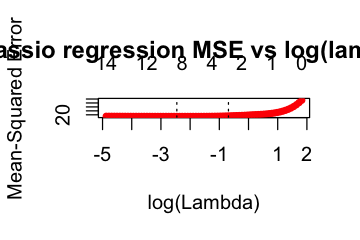

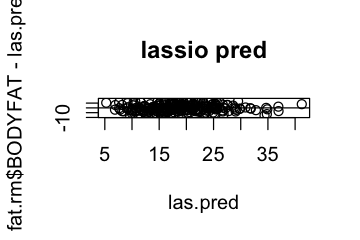

In [43]:
# LASSO
cv.fit=cv.glmnet(as.matrix(fat.rm[-1]),fat.rm$BODYFAT)#default 10 folds
plot(cv.fit,main="lassio regression MSE vs log(lambda)")
cv.fit$lambda.min
# cv.fit$lambda.1se
las=glmnet(as.matrix(fat.rm[-1]),fat.rm$BODYFAT,lambda = cv.fit$lambda.min)
las
# plot(las, xvar="lambda")
# “lambda.min”: lambda that gives minimum mse. May be too small to select features.
# “lambda.1se”: largest lambda s.t. mse is within 1 sd of minimum. Typically we choose lambda.1se.
round(coef(las,s = "lambda.min"),3)
round(coef(cv.fit, s = "lambda.1se" ),3)
round(vif(lm(BODYFAT~AGE+HEIGHT+ABDOMEN+WRIST,data=fat.rm)),3)
cv.fit$lambda.1se
las.pred=predict(las, s ="lambda.1se", newx = as.matrix(fat.rm[-1]))

# fat.rm$BODYFAT-las.pred
plot(las.pred,fat.rm$BODYFAT-las.pred,main="lassio pred");abline(h=0)
las.res=fat.rm$BODYFAT-las.pred

In [44]:
summary(model.bic.forward)


Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST, data = fat.rm)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.9385 -2.9118 -0.4086  2.9815  9.2198 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -24.97026    6.36973  -3.920 0.000115 ***
ABDOMEN       0.88700    0.05147  17.232  < 2e-16 ***
WEIGHT       -0.08541    0.02243  -3.808 0.000178 ***
WRIST        -1.25212    0.40873  -3.063 0.002437 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.974 on 241 degrees of freedom
Multiple R-squared:  0.7277,	Adjusted R-squared:  0.7243 
F-statistic: 214.7 on 3 and 241 DF,  p-value: < 2.2e-16


In [45]:
head(fat.rm)

BODYFAT,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
12.6,23,154.25,67.75,23.7,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
6.9,22,173.25,72.25,23.4,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
24.6,22,154.00,66.25,24.7,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
10.9,26,184.75,72.25,24.9,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
27.8,24,184.25,71.25,25.6,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7
20.6,24,210.25,74.75,26.5,39.0,104.5,94.4,107.8,66.0,42.0,25.6,35.7,30.6,18.8


ERROR: Error in value[[3L]](cond): invalid graphics state


Plot with title “”

ERROR: Error in int_abline(a = a, b = b, h = h, v = v, untf = untf, ...): invalid graphics state


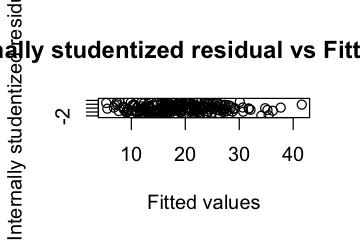

In [46]:
##  plot for standard / studentized res. vs fitted value
par(mfrow=c(2,2))
library(MASS)
lm.reg=model.bic.forward
data=fat.rm
plot(lm.reg)
index=1:nrow(data)
par(mfrow=c(1,1))
plot(lm.reg$fitted, stdres(lm.reg), xlab="Fitted values",
     ylab="Internally studentized residual",main="Internally studentized residual vs Fitted values") ;abline(h=0, lty=2)
# text(lm.reg$fitted[abs(stdres(lm.reg))>5], labels=index[abs(stdres(lm.reg))>5], cex=1, pos=2)
index[abs(stdres(lm.reg))>5]


plot(lm.reg$fitted, studres(lm.reg), type = "h", xlab="Fitted values vs Fitted values",
     ylab="Externally studentized residual",main="Externally studentized residual vs Fitted values");abline(h=c(0,-3,3), lty=2)
# text(lm.reg$fitted[abs(studres(lm.reg))>5], studres(lm.reg)[abs(studres(lm.reg))>5], labels=index[abs(studres(lm.reg))>5], cex=1, pos=2)
index[abs(studres(lm.reg))>5]
#


ERROR: Error in text.default(id_show, lm.reg.hats[id_show], labels = index[id_show], : zero-length 'labels' specified


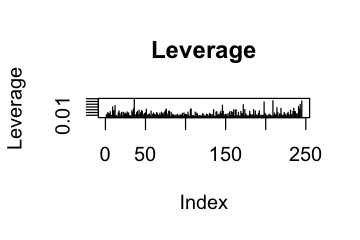

In [47]:
## leverage 
lm.reg.hats = hatvalues(lm.reg)
plot(lm.reg.hats, type = "h", ylab = "Leverage",main="Leverage") 
# id_show=order(lm.reg.hats,decreasing=T)[1:4]# the number of outlier can be adjusted
id_show=which(lm.reg.hats>4*p/n)
text(id_show,lm.reg.hats[id_show], labels = index[id_show], cex = 1) 
p=length(lm.reg$coefficients)-1;n=nrow(data)
abline(h=4*p/n,lty=2)#change 2 to 4
# abline(h=2*4/19, lty = 2) # h=2 times p / n =2 times 4 / 19
# order(lm.reg.hats,decreasing=T)[1:4]
id_show
#36 209 245 198 243

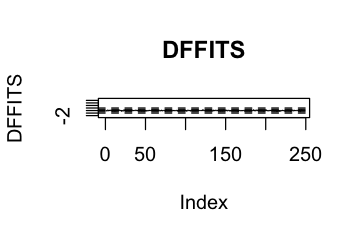

In [48]:
## DFFITS
lm.reg.dffits = dffits(lm.reg)
plot(lm.reg.dffits, type = "h", ylab = "DFFITS", ylim = c(-2.5,4.5),main="DFFITS") 
h=2*sqrt(p/n)
# text(which(abs(lm.reg.dffits)>max(1,h)),lm.reg.dffits[abs(lm.reg.dffits)>max(1,h)], labels = index[abs(lm.reg.dffits)>max(1,h)], cex = 0.8, pos = 1)
abline(h = c(-1,-2*sqrt(p/n), 0, 2*sqrt(p/n), 1), lty = 2) # specify your own h 
#

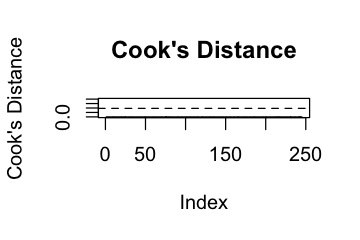

In [49]:
## cook's distance
lm.reg.cooksD = cooks.distance(lm.reg)
plot(lm.reg.cooksD, type = "h", ylab="Cook's Distance",ylim=c(0,2),main="Cook's Distance") 
h=qf(0.50,p,n-p)
# text(which(lm.reg.cooksD>h),lm.reg.cooksD[lm.reg.cooksD>h]-0.5, labels = index[lm.reg.cooksD>h], cex = 1)
# no influential outliers according to cook's distance here
abline(h=qf(0.50,p,n-p), lty=2) #check whether D_i > f_0.5,p,n-p

[1]  76 242 214 218 245

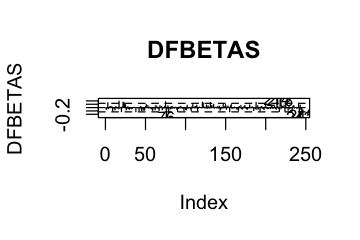

In [50]:
## dfbetas
lm.reg.dfbetas = dfbetas(lm.reg)
plot(lm.reg.dfbetas[,1], type = "h", ylab = "DFBETAS", xlab = "Index", main = "DFBETAS") 
id_show=order(abs(lm.reg.dfbetas[,1]),decreasing = T)[1:5]#the number can be adjusted
# id_show = which(abs(lm.reg.dfbetas)>2/sqrt(n))
text(id_show,lm.reg.dfbetas[,1][id_show], labels = index[id_show], cex = 0.8)
abline(h=c(-1, -2/sqrt(n), 0, 2/sqrt(n), 1), lty = 2) # specify your own threshold
id_show